In [1]:
import os
from PIL import Image
import pytorch_lightning as pl
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


In [2]:
class PACSDataset(Dataset):
    def __init__(self, root, mode, domains, contents, normalize):
        """
        root: str, root folder where PACS is located
        mode: str, choose one: "train", "val" or "test"
        domains: list of str ["art_painting", "cartoon", "photo", "sketch"]
        contents: list of str ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]
        normalize: bool, if True, data is normalized to fit a normal gaussian (determined by train set only)
        """
        super().__init__()
        self.mode = mode
        self.domains = domains
        self.contents = contents
        self.normalize = normalize
        self.domain_dict = {domain: torch.LongTensor([i]) for i, domain in enumerate(self.domains)}
        self.content_dict = {content: torch.LongTensor([i]) for i, content in enumerate(self.contents)}
        self.data_dir = f"{root}/PACS_{mode}"
        self.data = []
        for domain in os.listdir(f"{self.data_dir}"):
            if domain in self.domains:
                for content in os.listdir(f"{self.data_dir}/{domain}"):
                    if content in self.contents:
                        for file in os.listdir(f"{self.data_dir}/{domain}/{content}"):
                            self.data.append(f"{domain}/{content}/{file}")
        self.transform = self.get_transform(self.domains, self.normalize)

    def get_transform(self, domains, normalize):
        if normalize:
            data_mean_dict = {
                "art_painting": torch.Tensor([0.5117, 0.4888, 0.4654]),
                "cartoon": torch.Tensor([0.7263, 0.7117, 0.6890]),
                "photo": torch.Tensor([0.4741, 0.4597, 0.4400]),
                "sketch": torch.Tensor([0.8723, 0.8723, 0.8723]),
            }
            data_std_dict = {
                "art_painting": torch.Tensor([0.0203, 0.0248, 0.0271]),
                "cartoon": torch.Tensor([0.0536, 0.0640, 0.0735]),
                "photo": torch.Tensor([0.0324, 0.0312, 0.0360]),
                "sketch": torch.Tensor([0.0321, 0.0321, 0.0321]),
            }
            mean = torch.zeros(size=(3,))
            std = torch.zeros(size=(3,))
            for domain in self.domains:
                mean += data_mean_dict[domain] / len(self.domains)
                std += data_std_dict[domain] / len(self.domains)
            transform = transforms.Compose([
                transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(0.3, 0.3, 0.3, 0.3),
                transforms.RandomGrayscale(),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=mean, std=std, inplace=True),
            ])
        else:
            transform = transforms.Compose([
                transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(0.3, 0.3, 0.3, 0.3),
                transforms.RandomGrayscale(),
                transforms.ToTensor(),
            ])
        return transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = f"{self.data_dir}/{self.data[idx]}"
        # image = read_image(img_path)
        with Image.open(img_path) as image:
            image = self.transform(image)
            domain_name, content_name, filename = self.data[idx].split("/")
            domain = torch.nn.functional.one_hot(self.domain_dict[domain_name], num_classes=len(self.domains)).view(-1)
            content = torch.nn.functional.one_hot(self.content_dict[content_name], num_classes=len(self.contents)).view(-1)
            return image, domain, content, f"{domain_name}/{content_name}/{filename}"

        
class PACSDataModule(pl.LightningDataModule):
    def __init__(self, root, domains, contents, batch_size, num_workers, shuffle_all=False, normalize=True):
        """
        root: str, root folder where PACS is located
        domains: list of str ["art_painting", "cartoon", "photo", "sketch"]
        contents: list of str ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]
        batch_size: int, batch_size to use for the dataloaders
        num_workers: int, how many workers to use for the dataloader
        shuffle_all: bool, if True val and test dataloaders are shuffled as well
        normalize: bool, if True, data is normalized to fit a normal gaussian (determined by train set only)
        """
        super().__init__()
        self.root = root
        self.domains = domains
        self.contents = contents
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.shuffle_all = shuffle_all
        self.normalize = normalize

    def prepare_data(self):
        pass

    def setup(self, stage=None):
        if stage in (None, "fit"):
            self.pacs_train = PACSDataset(root=self.root, mode="train", domains=self.domains, contents=self.contents, normalize=self.normalize)
            self.pacs_val = PACSDataset(root=self.root, mode="val", domains=self.domains, contents=self.contents, normalize=self.normalize)
        if stage in (None, "test"):
            self.pacs_test = PACSDataset(root=self.root, mode="test", domains=self.domains, contents=self.contents, normalize=self.normalize)

    def train_dataloader(self):
        return DataLoader(self.pacs_train, batch_size=self.batch_size, shuffle=self.shuffle_all, num_workers=self.num_workers)
    
    def val_dataloader(self):
        return DataLoader(self.pacs_val, batch_size=self.batch_size, shuffle=self.shuffle_all, num_workers=self.num_workers)
    
    def test_dataloader(self):
        return DataLoader(self.pacs_test, batch_size=self.batch_size, shuffle=self.shuffle_all, num_workers=self.num_workers)
    

In [3]:
domains = ["art_painting", "cartoon", "photo", "sketch"]
contents =  ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]
batch_size = 4
num_workers = 4
root = "../data"
dm = PACSDataModule(root=root, domains=domains, contents=contents, batch_size=batch_size, num_workers=num_workers, normalize=True)
dm.setup()

In [4]:
import numpy as np

In [5]:
import matplotlib.pyplot as plt

In [6]:
def gauss(x):
    return 1 / np.sqrt(2 * np.pi) * np.exp(-x ** 2 / 2)

In [10]:
data = torch.load("data.pt").flatten().numpy()
print(data.shape)
xx = np.linspace(-5, 5, 100)
print(xx.shape)

(150528,)
(100,)


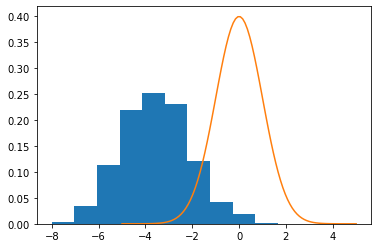

-8.00009 1.6479299


In [13]:
plt.hist(data, density=True)
plt.plot(xx, gauss(xx))
plt.show()
print(data.min(), data.max())

(1000,)


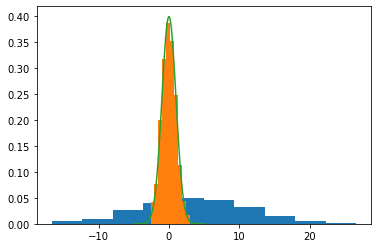

In [22]:
a = np.random.normal(loc=4, scale=8, size=1000)
b = (a - a.mean()) / a.std()
print(a.shape)
plt.hist(a, density=True)
plt.hist(b, density=True)
plt.plot(xx, gauss(xx))
plt.show()